In [4]:

!pip install pycuda

import numpy as np
import timeit
import scipy.cluster
import scipy.cluster.vq
import pycuda.driver as drv
import math
from numpy.random import randint
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit

vals = []

def cu_vq(obs, clusters):
    global vals
    kernel_code_template = """
     #include "float.h"
      __device__ void loadVector(float *target, float* source, int dimensions ){
          for( int i = 0; i < dimensions; i++ ) target[i] = source[i];
      }
      // the kernel definition
      __global__ void cu_vq(float *g_idata, float *g_centroids, int * cluster, float *min_dist, int numClusters, int numDim, int numPoints) {
        int valindex = blockIdx.x * blockDim.x + threadIdx.x ;
        __shared__ float mean[%(DIMENSIONS)s];
        float minDistance = FLT_MAX;
        int myCentroid = 0;
        if(valindex < numPoints){
          for(int k=0;k<numClusters;k++){
            if(threadIdx.x == 0) loadVector( mean, &g_centroids[k*(numDim)], numDim );
            __syncthreads();
            float distance = 0.0;
            for(int i=0;i<numDim;i++){
              float increased_distance = (g_idata[valindex+i*(numPoints)] -mean[i]);
              distance = distance +(increased_distance * increased_distance);
            }
            if(distance<minDistance) {
              minDistance = distance ;
              myCentroid = k;
            }
          }
          cluster[valindex]=myCentroid;
          min_dist[valindex]=sqrt(minDistance);
        }
      }
    """
    nclusters = clusters.shape[0]
    points = obs.shape[0]
    dimensions = obs.shape[1]
    block_size = 512
    blocks = int(math.ceil(float(points) / block_size))

    kernel_code = kernel_code_template % {'DIMENSIONS': dimensions}
    mod = compiler.SourceModule(kernel_code)

    dataT = obs.T.astype(np.float32).copy()
    clusters = clusters.astype(np.float32)

    cluster = gpuarray.zeros(points, dtype=np.int32)
    min_dist = gpuarray.zeros(points, dtype=np.float32)

    kmeans_kernel = mod.get_function('cu_vq')

    start = drv.Event()
    end=drv.Event()
    #Start Time
    start.record()
    
    kmeans_kernel(driver.In(dataT), driver.In(clusters), cluster, min_dist, np.int32(nclusters), np.int32(dimensions), np.int32(points), grid=(blocks, 1), block=(block_size, 1, 1),)

    end.record()
    end.synchronize()
    #Measure time difference, give time in milliseconds, which is converted to seconds.
    secs = start.time_till(end)*1e-3
    
    vals.append(secs)

    return cluster.get(), min_dist.get()

times = []

def avg(A): return sum(A)/len(A)

def _kmeans_cuda(obs, guess, thresh=1e-5):
    global vals, times
    code_book = np.array(guess, copy=True)
    avg_dist = []
    diff = thresh + 1.
    while diff > thresh:
        nc = code_book.shape[0]
        #compute membership and distances between obs and code_book
        obs_code, distort = cu_vq(obs, code_book)
        avg_dist.append(np.mean(distort, axis=-1))
        #recalc code_book as centroids of associated obs
        if(diff > thresh):
            has_members = []
            for i in np.arange(nc):
                cell_members = np.compress(np.equal(obs_code, i), obs, 0)
                if cell_members.shape[0] > 0:
                    code_book[i] = np.mean(cell_members, 0)
                    has_members.append(i)
            #remove code_books that didn't have any members
            code_book = np.take(code_book, has_members, 0)
        if len(avg_dist) > 1:
            diff = avg_dist[-2] - avg_dist[-1]
    return code_book, avg_dist[-1]


def kmeans_cuda(obs, k_or_guess, iter=20, thresh=1e-5):
    global vals, times
    vals = []
    if int(iter) < 1:
        raise ValueError('iter must be at least 1.')
    if type(k_or_guess) == type(np.array([])):
        guess = k_or_guess
        if guess.size < 1:
            raise ValueError("Asked for 0 cluster ? initial book was %s" % \
                             guess)
        result = _kmeans_cuda(obs, guess, thresh=thresh)
    else:
        #initialize best distance value to a large value
        best_dist = np.inf
        No = obs.shape[0]
        k = k_or_guess
        if k < 1:
            raise ValueError("Asked for 0 cluster ? ")
        for i in range(iter):
            #the intial code book is randomly selected from observations
            guess = np.take(obs, randint(0, No, k), 0)
            book, dist = _kmeans_cuda(obs, guess, thresh=thresh)
            if dist < best_dist:
                best_book = book
                best_dist = dist
        result = best_book, best_dist
    times.append(avg(vals))

    return result

serial = []

def main():
    global serial
    dimensions = 128
    nclusters = 256

    rounds = 3  # for timeit
    rtol = 0.001  # for the relative error calculation

    for i in range(10000, 200001, 10000):
      points =  i
      data = np.random.randn(points, dimensions).astype(np.float32)
      print("points", points, "  dimensions", dimensions, "  nclusters", nclusters, "  rounds", rounds)
      clusters = data[:nclusters]
      gpu_book, gpu_dist = kmeans_cuda(data, clusters)
      
      serial.append((timeit.timeit(lambda: scipy.cluster.vq.kmeans(data, nclusters, iter=1), number=rounds)))
      """
          
          cpu_book, cpu_dist = scipy.cluster.vq.kmeans(data, clusters)

          print('Cuda k means', timeit.timeit(lambda: kmeans_cuda(data, clusters, iter=1), number=rounds))
          gpu_book, gpu_dist = kmeans_cuda(data, clusters)
          errorsCPU_GPU = nclusters * dimensions - sum(1 for a, b in zip(gpu_book.ravel(), cpu_book.ravel()) if (abs(a - b) <= (rtol * abs(b))))
          print("")
          print("--------------------------------------------------------------")
          print("")

      """
     
main()

     |████████████████████████████████| 1.7MB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627498 sha256=75cc07c96c5c2bee06360da7128647cbd3051ccd5cd3021552a5c8810824e3fa
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=ef124e01622ededee190323991cdb320b1d8a7625f166f07150a5daad8771779
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools
points 10000   dimensions 128   nclusters 256   rounds 3
points 20000   dimensions 128   nclusters 256   rounds 3
points

In [5]:
times

[0.00768739292200874,
 0.013912490970210028,
 0.020134094238281247,
 0.026420715527656752,
 0.03392344948341106,
 0.04117579008031774,
 0.04650907355088453,
 0.051385230803153874,
 0.05936632522164958,
 0.06626109409332276,
 0.07211501084512738,
 0.07796154082448858,
 0.08495027057035467,
 0.09068439654300085,
 0.09603167036103039,
 0.10055326781875781,
 0.10875428097373568,
 0.11408188135937009,
 0.12109906412285072,
 0.12676247499573906]

In [6]:
serial

[1.6783708899999965,
 3.9253869039999927,
 7.957719517999976,
 11.728691054000024,
 16.94590404799999,
 21.156309604000057,
 29.38090872800001,
 35.832869491,
 42.34770202599998,
 47.59458667700005,
 58.02551512299988,
 63.74640980100003,
 71.65057582099985,
 81.48665673799997,
 85.65846303400008,
 96.17798618500001,
 117.63778338499992,
 111.36060530000009,
 130.84915105500022,
 123.54648228500037]

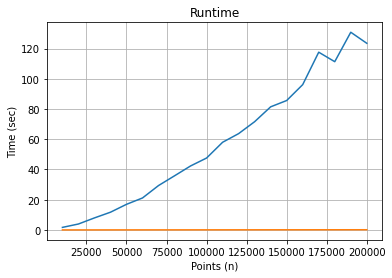

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list(range(10000, 200001, 10000)), serial)
ax.plot(list(range(10000, 200001, 10000)), times)

ax.set(xlabel='Points (n)', ylabel='Time (sec)',
       title='Runtime')
ax.grid()


fig.savefig("test.png")

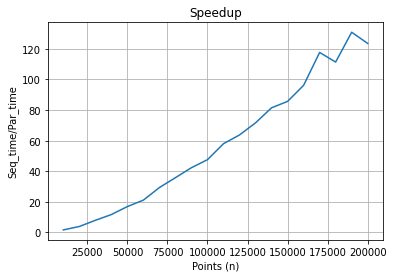

In [10]:
speedup = []
for i in range(len(serial)): speedup.append(serial[i]/times[i])
fig, ax = plt.subplots()
ax.plot(list(range(10000, 200001, 10000)), serial)
ax.set(xlabel='Points (n)', ylabel='Seq_time/Par_time',
       title='Speedup')
ax.grid()

fig.savefig("test.png")

In [13]:
import sys
dimensions = 128
nclusters = 256

rounds = 3  # for timeit
rtol = 0.001  # for the relative error calculation
sz = []
for i in range(10000, 200001, 10000):
      points =  i
      data = np.random.randn(points, dimensions).astype(np.float32)
      byts = sys.getsizeof(data)
      mega = byts*(1e-6)
      sz.append(1000+mega)
sz


[1005.120112,
 1010.240112,
 1015.360112,
 1020.480112,
 1025.600112,
 1030.720112,
 1035.840112,
 1040.960112,
 1046.080112,
 1051.200112,
 1056.3201119999999,
 1061.440112,
 1066.5601120000001,
 1071.680112,
 1076.800112,
 1081.920112,
 1087.040112,
 1092.160112,
 1097.280112,
 1102.400112]

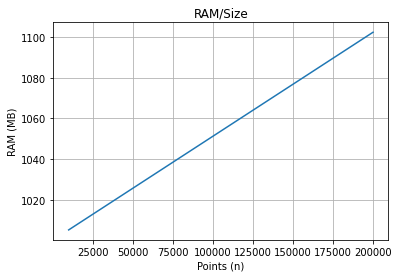

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list(range(10000, 200001, 10000)), sz)

ax.set(xlabel='Points (n)', ylabel='RAM (MB)',
       title='RAM/Size')
ax.grid()